In [ ]:
# https://csaybar.github.io/blog/2019/05/19/titanic/

In [22]:
!pip3 install lightgbm
!pip3 install bayesian-optimization

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [1]:

import sklearn
from sklearn.model_selection import train_test_split
import joblib
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import numpy as np

import urllib

import pandas as pd

In [7]:
%load_ext autoreload
%autoreload 2

In [14]:
import sys
sys.path.append('/alloc/data/fury_fda-general-analysis/')
from commons.modelling_tools import clean_dataset, bayes_parameter_opt_lgb
import commons.metrics as met


# read data

In [44]:
# Download the dataset
url = 'https://raw.githubusercontent.com/csaybar/Titanic/master/'
urllib.request.urlretrieve(url+'train.csv', 'train.csv')
urllib.request.urlretrieve(url+'test.csv', 'test.csv')

#Let’s read in and take a peek at the data.
basedataset = pd.read_csv('train.csv')
dataset_valid =  pd.read_csv('test.csv')

In [45]:
basedataset.rename(columns={'Survived': 'target'}, inplace=True)

In [46]:
basedataset.groupby(['target'], as_index=False).agg({"PassengerId":"count"})

,target,PassengerId
0,0,549
1,1,342


In [82]:
basedataset.head(3)

,PassengerId,target,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


# data preparation

In [50]:
X = basedataset[basedataset.columns.difference(['target'])]
X = clean_dataset(X,categorical_cols=['Sex','Cabin','Embarked'],canary=3,vars_to_drop=['Name','Ticket'])
y = basedataset['target'].astype('int')

canary features


In [51]:
### Modelo LIGHTGBM
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# train df
lgb_train = lgb.Dataset(X_train, y_train)

# test df
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [52]:
# optimizar
opt_params = bayes_parameter_opt_lgb(X_train, y_train, X_test, y_test, init_round=5, opt_round=15, random_seed=6)

|   iter    |  target   | baggin... | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8519   |  0.9098   |  6.576    |  0.5822   |  2.724    |  1.271    |  0.06494  |  6.746    |  45.13    |  0.0964   |  23.42    |
|  2        |  0.8609   |  0.9583   |  5.644    |  0.5544   |  4.628    |  0.2131   |  0.009626 |  5.081    |  42.47    |  0.07804  |  40.45    |
|  3        |  0.8537   |  0.9957   |  6.996    |  0.4692   |  3.903    |  0.3548   |  0.06435  |  5.572    |  47.51    |  0.05266  |  24.51    |
|  4        |  0.8605   |  0.8529   |  6.871    |  0.4649   |  2.842    |  0.05637  |  0.06215  |  7.442    |  32.76    |  0.09443  |  33.86    |
|  5        |  0.8742   |  0.8719   |  5.185    |  0.6581   |  0.3011   |  2.0      |  0.06739  |  5.839    |  10.8     |  0

In [53]:
params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'l2', 'l1','l2_root','mape', 'rmse', 'auc'},
        'learning_rate': opt_params['params']['learning_rate'],
        'feature_fraction': opt_params['params']['feature_fraction'],
        'max_depth': opt_params['params']['max_depth'],
        'min_child_weight': opt_params['params']['min_child_weight'],
        'min_split_gain': opt_params['params']['min_split_gain'],
        'lambda_l1': opt_params['params']['lambda_l1'],
        'lambda_l1': opt_params['params']['lambda_l2'],
        'num_leaves': opt_params['params']['num_leaves'],
        'bagging_freq': int(opt_params['params']['bagging_freq']),
        'n_jobs':40,
        'verbose': 0
    }

In [54]:
# Entreno el modelo (con los codigos de MLA)
# https://github.com/Microsoft/LightGBM/blob/2e93cdab9eee02d4d7f5cb3b6b31128dec94e25e/examples/python-guide/plot_example.py#L32-L47
evals_result = {}  # to record eval results for plotting
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=50,
                evals_result=evals_result,
                valid_sets=lgb_eval,
                early_stopping_rounds=30)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 0.490474	valid_0's auc: 0.850318	valid_0's l2: 0.240564	valid_0's mape: 0.475103	valid_0's l1: 0.475103
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 0.489824	valid_0's auc: 0.852083	valid_0's l2: 0.239927	valid_0's mape: 0.474447	valid_0's l1: 0.474447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 0.48958	valid_0's auc: 0.854803	valid_0's l2: 0.239688	valid_0's mape: 0.474208	valid_0's l1: 0.474208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 0.48932	valid_0's a

# metricas

In [67]:
import commons.metrics as met

ROC curve & AUC..


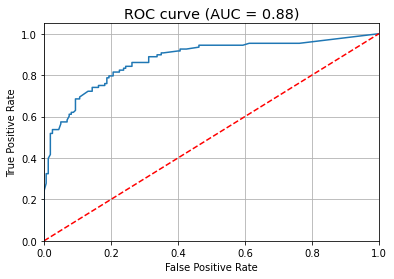

In [57]:
import sklearn.metrics as sklm
#roc_curve(y_test, y_pred_prob, model_id)
plot_roc_curve(y_test, gbm.predict(X_test),'model1')

In [56]:
max_ks, cutoff = met.best_cutoff(y_test, gbm.predict(X_test),'model1')
met.best_cutoff(y_test, gbm.predict(X_test),'model1')

Best cutoff..
Best cutoff..


(0.6085648148148148, 0.3743809022054264)

In [58]:
reporte = obtain_metrics(gbm.predict(X_test), y_test, cutoff, max_ks)
obtain_metrics(gbm.predict(X_test), y_test, cutoff, max_ks)

{'Cutoff': 0.374,
 'KS': 0.609,
 'Accuracy': 80.22,
 'Precision (1)': 72.73,
 'Recall (1)': 81.48,
 'Mean absolute error': 0.2,
 'mean squared error': 0.2,
 'Root mean squared error': 0.44}

In [60]:
print(classification_report(y_test,y_cut_off))

              precision    recall  f1-score   support

           0       0.86      0.79      0.83       160
           1       0.73      0.81      0.77       108

    accuracy                           0.80       268
   macro avg       0.80      0.80      0.80       268
weighted avg       0.81      0.80      0.80       268



> Confussion matrix


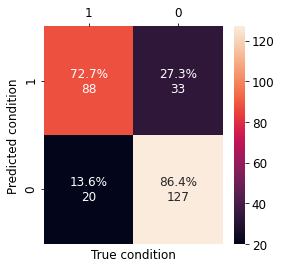

> Reporte:
1


In [59]:
y_pred_prob = gbm.predict(X_test)
y_cut_off = y_pred_prob >= cutoff
cm, annot = cm_analysis(y_test, y_cut_off)
print_confussion_matrix_and_report(cm, annot, '1')

In [74]:
met.ks_table(X_test,y_test,model_name=gbm,target='target', prob='pred',decimal=3)

,prob_group,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,TP,FP,TN,FN,Precision_(1),recall_(1),F1-score(1),Precision_(0),recall_(0),F1-score(0),KS
0,0.401,0.401327,0.401327,12,0,11.11%,0.00%,11.11%,0.00%,12,0,160,96,1.00,0.11,0.20,0.62,1.00,0.77,11.1
1,0.400,0.400399,0.400399,6,0,5.56%,0.00%,16.67%,0.00%,18,0,160,90,1.00,0.17,0.29,0.64,1.00,0.78,16.7
2,0.398,0.398081,0.398081,2,0,1.85%,0.00%,18.52%,0.00%,20,0,160,88,1.00,0.19,0.32,0.65,1.00,0.79,18.5
3,0.397,0.397913,0.397913,1,0,0.93%,0.00%,19.44%,0.00%,21,0,160,87,1.00,0.19,0.32,0.65,1.00,0.79,19.4
4,0.395,0.395464,0.395892,4,0,3.70%,0.00%,23.15%,0.00%,25,0,160,83,1.00,0.23,0.37,0.66,1.00,0.80,23.1
5,0.394,0.394749,0.394924,5,1,4.63%,0.62%,27.78%,0.62%,30,1,159,78,0.97,0.28,0.43,0.67,0.99,0.80,27.2
6,0.393,0.393782,0.393782,1,0,0.93%,0.00%,28.70%,0.62%,31,1,159,77,0.97,0.29,0.45,0.67,0.99,0.80,28.1
7,0.392,0.392103,0.392103,1,0,0.93%,0.00%,29.63%,0.62%,32,1,159,76,0.97,0.30,0.46,0.68,0.99,0.81,29.0
8,0.391,0.391051,0.391051,2,0,1.85%,0.00%,31.48%,0.62%,34,1,159,74,0.97,0.31,0.47,0.68,0.99,0.81,30.9
9,0.390,0.390492,0.390492,1,0,0.93%,0.00%,32.41%,0.62%,35,1,159,73,0.97,0.32,0.48,0.69,0.99,0.81,31.8


In [ ]:
# features

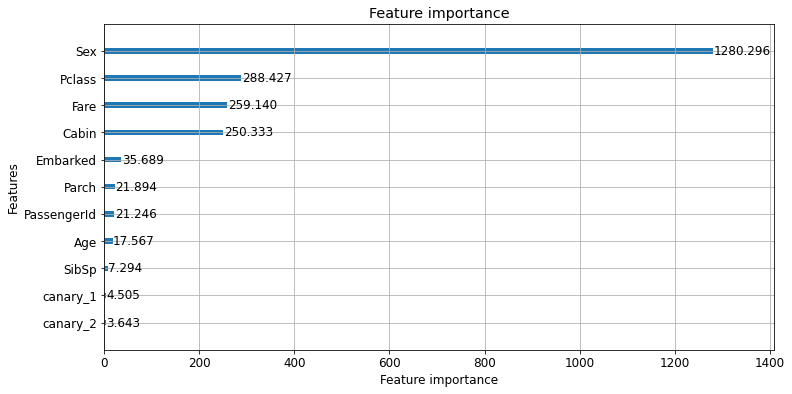

In [78]:
lgb.plot_importance(gbm, figsize=(12, 6),importance_type='gain', max_num_features=20,grid=True);

# "mujeres y ninos primero"

In [77]:
df_imporance = get_importance_df(X_test,y_test,gbm)
df_imporance.sort_values(by=['importance_gain'],ascending=False).head(20)

,feature,importance_gain,importance_split,trn_score
7,Sex,1280.295975,9,0.875347
6,Pclass,288.427200,6,0.875347
3,Fare,259.139679,17,0.875347
1,Cabin,250.332754,19,0.875347
2,Embarked,35.688610,6,0.875347
4,Parch,21.893870,7,0.875347
5,PassengerId,21.245551,6,0.875347
0,Age,17.566710,5,0.875347
8,SibSp,7.293810,3,0.875347
9,canary_1,4.505382,5,0.875347
